# horror_spooky_eda

## 这部分做最基础的统计特征挖掘

In [3]:
import pandas as pd
#pd.set_option('max_colwidth', 500)
filepath = 'C:/Users\lenovo/Documents/'

In [4]:
train_data = pd.read_csv(filepath+'train.csv')
train_data.head(5)

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [5]:
train_data.isnull().sum()

id        0
text      0
author    0
dtype: int64

In [6]:
train_data.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id08815,"On one side I could view the entire city as it sloped from the plaza down to the old river bank; on the other side, in startling proximity, I was confronted by the richly ornate and perfectly preserved facade of a great building, evidently a temple, hollowed from the solid rock.",EAP
freq,1,1,7900


#### 训练集一个有19579条记录，没有缺失值。第一列是unique_id，第二列是一句文本，第三列是作者。作者一共有三个，分别是EAP,HPL和MWS。从frequence来看，训练集中的样本可能是分布不均的。同时，训练集的id有可能可以作为提高模型结果的trick。

In [9]:
train_data.groupby(train_data.author).id.count()

author
EAP    7900
HPL    5635
MWS    6044
Name: id, dtype: int64

####  不确定这个分布需不需要做调整。接下来看看每个作者写的句子长度有没有差异。

In [9]:
train_data['text_split'] = train_data.text.apply(lambda x:x.split())

In [10]:
train_data['text_len'] = train_data.text_split.apply(lambda x: len(x))

#### 可以看出超长句子（len>=300）基本可以判断为MWS的句子，也许可以作为一个特征值。但这个超长句子也可能是异常值，还需要看看去除异常值后句子长度的分布差异。同时看到，三个作家的句子长度都是右偏的。这可能是人类写作的一个正常分布？但HPL的左偏程度非常小，可能是HPL的写作方式和别人不一样，打字机、电脑、写字。也许这个特征也可以用起来？

In [13]:
# 先打印所有的超长句子看看,共有五条，全部是MWS
train_data[train_data.text_len>=300]

,id,text,author,text_split,text_len
3956,id20439,To chambers of painted state farewell To midni...,MWS,"[To, chambers, of, painted, state, farewell, T...",377
4184,id20549,As for those who in your world knew not the lo...,MWS,"[As, for, those, who, in, your, world, knew, n...",335
9215,id27184,Diotima approached the fountain seated herself...,MWS,"[Diotima, approached, the, fountain, seated, h...",861
10939,id13677,They are gone for ever great as my power is I ...,MWS,"[They, are, gone, for, ever, great, as, my, po...",445
18107,id17485,Oh no I will become wise I will study my own h...,MWS,"[Oh, no, I, will, become, wise, I, will, study...",594


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


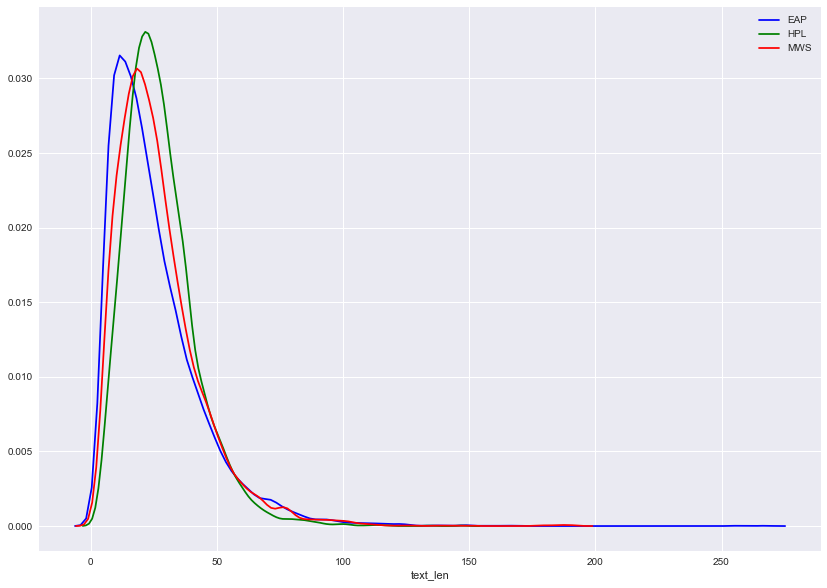

In [14]:
#去除这五条后的分布情况,好像没什么区别
f = plt.figure(figsize=(14,10))
sns.distplot(train_data[(train_data.author=='EAP')&(train_data.text_len<=300)].text_len,color='blue',label='EAP',hist=False)
sns.distplot(train_data[(train_data.author=='HPL')&(train_data.text_len<=300)].text_len,color='green',label='HPL',hist=False)
sns.distplot(train_data[(train_data.author=='MWS')&(train_data.text_len<=300)].text_len,color='red',label='MWS',hist=False)
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import math
import numpy as np

# 最好能再多找几个特征出来，因为一把stopwords去掉很多有意思的特征就没了。
****
### 这么看起来好像看不出有什么使用词语上的差异（虽然这么说，但是有些特征还是很明显的，比如说MWS使用her的频次比其他两个作家要高许多，这说明他的作品里面可能会涉及到较多的女性（女性向？）；还有my的频次差异，可能是第一视角作品比较多，感觉MWS在人称me,my,you,her这种东西上频次明显高出不少）。
### 接下来去掉一些stopwords后再来做这个操作。然后我们就要开始使用nltk这个包了，使用nltk后也可以减小前面几部分词中的误差。

这张图的横坐标是词频，纵坐标是每个作家文本中频率最高的50个word,所以可以看一下和上图有什么区别。看看每个作家有没有什么特殊的用词习惯

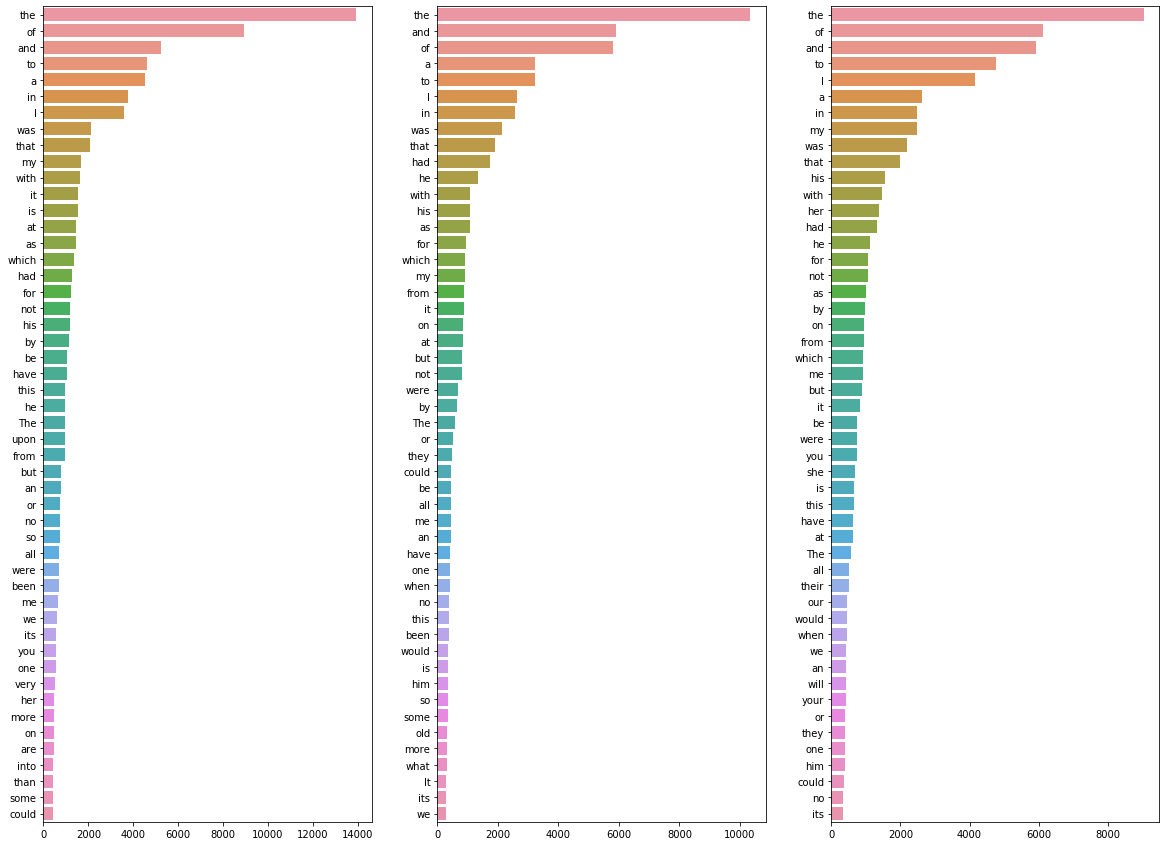

In [14]:
eap_word = train_data[train_data.author=='EAP'].text.str.split(expand=True).unstack().value_counts()
hpl_word = train_data[train_data.author=='HPL'].text.str.split(expand=True).unstack().value_counts()
mws_word = train_data[train_data.author=='MWS'].text.str.split(expand=True).unstack().value_counts()
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_word[0:50].keys(),x=eap_word[0:50].values,ax=ax1)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_word[0:50].keys(),x=hpl_word[0:50].values,ax=ax2)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_word[0:50].keys(),x=mws_word[0:50].values,ax=ax3)
plt.show()

In [15]:
import nltk

###  遇到一个问题，anaconda提供的nltk都过时了，需要用nltk.download()更新

In [19]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [20]:
train_data['word_split'] = train_data.text.apply(lambda x:nltk.word_tokenize(str(x)))

In [21]:
train_data['word_tag'] = train_data.word_split.apply(lambda x:nltk.pos_tag(x))

In [24]:
train_data

,id,text,author,text_split,text_len,word_split,word_tag
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP,"[This, process,, however,, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, dungeon;, as, I, might, make, its, circuit,, and, return, to, the, point, whence, I, set, out,, without, being, aware, of, the, fact;, so, perfectly, uniform, seemed, the, wall.]",41,"[This, process, ,, however, ,, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, dungeon, ;, as, I, might, make, its, circuit, ,, and, return, to, the, point, whence, I, set, out, ,, without, being, aware, of, the, fact, ;, so, perfectly, uniform, seemed, the, wall, .]","[(This, DT), (process, NN), (,, ,), (however, RB), (,, ,), (afforded, VBD), (me, PRP), (no, DT), (means, NNS), (of, IN), (ascertaining, VBG), (the, DT), (dimensions, NNS), (of, IN), (my, PRP$), (dungeon, NN), (;, :), (as, IN), (I, PRP), (might, MD), (make, VB), (its, PRP$), (circuit, NN), (,, ,), (and, CC), (return, NN), (to, TO), (the, DT), (point, NN), (whence, NN), (I, PRP), (set, VBP), (out, RP), (,, ,), (without, IN), (being, VBG), (aware, JJ), (of, IN), (the, DT), (fact, NN), (;, :), (..."
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,"[It, never, once, occurred, to, me, that, the, fumbling, might, be, a, mere, mistake.]",14,"[It, never, once, occurred, to, me, that, the, fumbling, might, be, a, mere, mistake, .]","[(It, PRP), (never, RB), (once, RB), (occurred, VBD), (to, TO), (me, PRP), (that, IN), (the, DT), (fumbling, NN), (might, MD), (be, VB), (a, DT), (mere, JJ), (mistake, NN), (., .)]"
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP,"[In, his, left, hand, was, a, gold, snuff, box,, from, which,, as, he, capered, down, the, hill,, cutting, all, manner, of, fantastic, steps,, he, took, snuff, incessantly, with, an, air, of, the, greatest, possible, self, satisfaction.]",36,"[In, his, left, hand, was, a, gold, snuff, box, ,, from, which, ,, as, he, capered, down, the, hill, ,, cutting, all, manner, of, fantastic, steps, ,, he, took, snuff, incessantly, with, an, air, of, the, greatest, possible, self, satisfaction, .]","[(In, IN), (his, PRP$), (left, JJ), (hand, NN), (was, VBD), (a, DT), (gold, JJ), (snuff, NN), (box, NN), (,, ,), (from, IN), (which, WDT), (,, ,), (as, IN), (he, PRP), (capered, VBD), (down, RP), (the, DT), (hill, NN), (,, ,), (cutting, VBG), (all, DT), (manner, NN), (of, IN), (fantastic, JJ), (steps, NNS), (,, ,), (he, PRP), (took, VBD), (snuff, NN), (incessantly, RB), (with, IN), (an, DT), (air, NN), (of, IN), (the, DT), (greatest, JJS), (possible, JJ), (self, NN), (satisfaction, NN), (., .)]"
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS,"[How, lovely, is, spring, As, we, looked, from, Windsor, Terrace, on, the, sixteen, fertile, counties, spread, beneath,, speckled, by, happy, cottages, and, wealthier, towns,, all, looked, as, in, former, years,, heart, cheering, and, fair.]",34,"[How, lovely, is, spring, As, we, looked, from, Windsor, Terrace, on, the, sixteen, fertile, counties, spread, beneath, ,, speckled, by, happy, cottages, and, wealthier, towns, ,, all, looked, as, in, former, years, ,, heart, cheering, and, fair, .]","[(How, WRB), (lovely, RB), (is, VBZ), (spring, JJ), (As, IN), (we, PRP), (looked, VBD), (from, IN), (Windsor, NNP), (Terrace, NNP), (on, IN), (the, DT), (sixteen, JJ), (fertile, JJ), (counties, NNS), (spread, VBP), (beneath, NN), (,, ,), 

In [23]:
def get_tag(x):
    a = {}
    for i in x:
        if str(i[1]) not in a:
            a[str(i[1])]=0
        else:
            a[str(i[1])]+=1
    return a
train_data.word_tag.apply(lambda x:get_tag(x))


0                                                 {'DT': 5, 'NN': 7, ',': 3, 'RB': 2, 'VBD': 1, 'PRP': 2, 'NNS': 1, 'IN': 4, 'VBG': 1, 'PRP$': 1, ':': 1, 'MD': 0, 'VB': 0, 'CC': 0, 'TO': 0, 'VBP': 0, 'RP': 0, 'JJ': 1, '.': 0}
1                                                                                                                            {'PRP': 1, 'RB': 1, 'VBD': 0, 'TO': 0, 'IN': 0, 'DT': 1, 'NN': 1, 'MD': 0, 'VB': 0, 'JJ': 0, '.': 0}
2                                                                                   {'IN': 5, 'PRP$': 0, 'JJ': 3, 'NN': 8, 'VBD': 2, 'DT': 4, ',': 3, 'WDT': 0, 'PRP': 1, 'RP': 0, 'VBG': 0, 'NNS': 0, 'RB': 0, 'JJS': 0, '.': 0}
3                                                                {'WRB': 0, 'RB': 0, 'VBZ': 0, 'JJ': 4, 'IN': 5, 'PRP': 0, 'VBD': 1, 'NNP': 1, 'DT': 1, 'NNS': 3, 'VBP': 0, 'NN': 3, ',': 2, 'VBN': 0, 'CC': 1, 'JJR': 0, '.': 0}
4                                                                           {'VBG': 1, 'NN': 4, 

In [34]:
categories=['DT','CC','CD','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNP','NNPS','NNS','PDT','POS','PRP','PRP_','RB','RBR','RBS','RP'
            ,'SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP_','WRB','dollar']
ep=[]
for i in range(len(train_data)):
    ep.append([])
for c in categories:
    train_data[c]=ep

In [7]:
for i in range(len(train_data.word_tag)):
    for j in train_data.word_tag[i]:
        if j[1] == 'DT':
            train_data.DT[i].append(j[0])
        elif j[1] == 'CC':
            train_data.CC[i].append(j[0])
        elif j[1] == 'CD':
            train_data.CD[i].append(j[0])
        elif j[1] == 'EX':
            train_data.EX[i].append(j[0])
        elif j[1] == 'FW':
            train_data.FW[i].append(j[0])
        if j[1] == 'IN':
            train_data.IN[i].append(j[0])
        if j[1] == 'JJ':
            train_data.JJ[i].append(j[0])
        if j[1] == 'JJR':
            train_data.JJR[i].append(j[0])
        if j[1] == 'JJS':
            train_data.JJS[i].append(j[0])
        if j[1] == 'LS':
            train_data.LS[i].append(j[0])
        if j[1] == 'MD':
            train_data.MD[i].append(j[0])
        if j[1] == 'NN':
            train_data.NN[i].append(j[0])
        if j[1] == 'NNP':
            train_data.NNP[i].append(j[0])
        if j[1] == 'NNPS':
            train_data.NNPS[i].append(j[0])
        if j[1] == 'NNS':
            train_data.NNS[i].append(j[0])
        if j[1] == 'PDT':
            train_data.PDT[i].append(j[0])
        if j[1] == 'POS': 
            train_data.POS[i].append(j[0])
        if j[1] == 'PRP':
            train_data.PRP[i].append(j[0])
        if j[1] == 'PRP$':
            train_data.PRP_[i].append(j[0])
        if j[1] == 'RB':
            train_data.RB[i].append(j[0])
        if j[1] == 'RP':
            train_data.RP[i].append(j[0])
        if j[1] == 'SYM':
            train_data.SYM[i].append(j[0])
        if j[1] == 'TO':
            train_data.TO[i].append(j[0])
        if j[1] == 'UH':
            train_data.UH[i].append(j[0])
        if j[1] == 'VB':
            train_data.VB[i].append(j[0])
        if j[1] == 'VBD':
            train_data.VBD[i].append(j[0])
        if j[1] == 'VBG':
            train_data.VBG[i].append(j[0])
        if j[1] == 'VBP':
            train_data.VBP[i].append(j[0])
        if j[1] == 'VBZ':
            train_data.VBZ[i].append(j[0])
        if j[1] == 'WDT':
            train_data.WDT[i].append(j[0])
        if j[1] == 'WP':
            train_data.WP[i].append(j[0])
        if j[1] == 'WP$':
            train_data.WP_[i].append(j[0])
        if j[1] == 'WRB':
            train_data.WRB[i].append(j[0])
        if j[1] == '$':
            train_data.dollar[i].append(j[0]) 

        

In [45]:
EAP_DT=[]
for i in range(len(train_data.DT)):
    if train_data.author[i] == 'EAP':
        EAP_DT+= train_data.DT[i]

HPL_DT=[]
for i in range(len(train_data.DT)):
    if train_data.author[i] == 'HPL':
        HPL_DT+= train_data.DT[i]

MWS_DT=[]
for i in range(len(train_data.DT)):
    if train_data.author[i] == 'MWS':
        MWS_DT+= train_data.DT[i]


In [46]:
freq_EAP_DT = nltk.FreqDist(EAP_DT)
freq_HPL_DT = nltk.FreqDist(HPL_DT)
freq_MWS_DT = nltk.FreqDist(MWS_DT)

In [59]:
eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_DT.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_DT.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_DT.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_listkey.append(key)
    mws_listval.append(val)


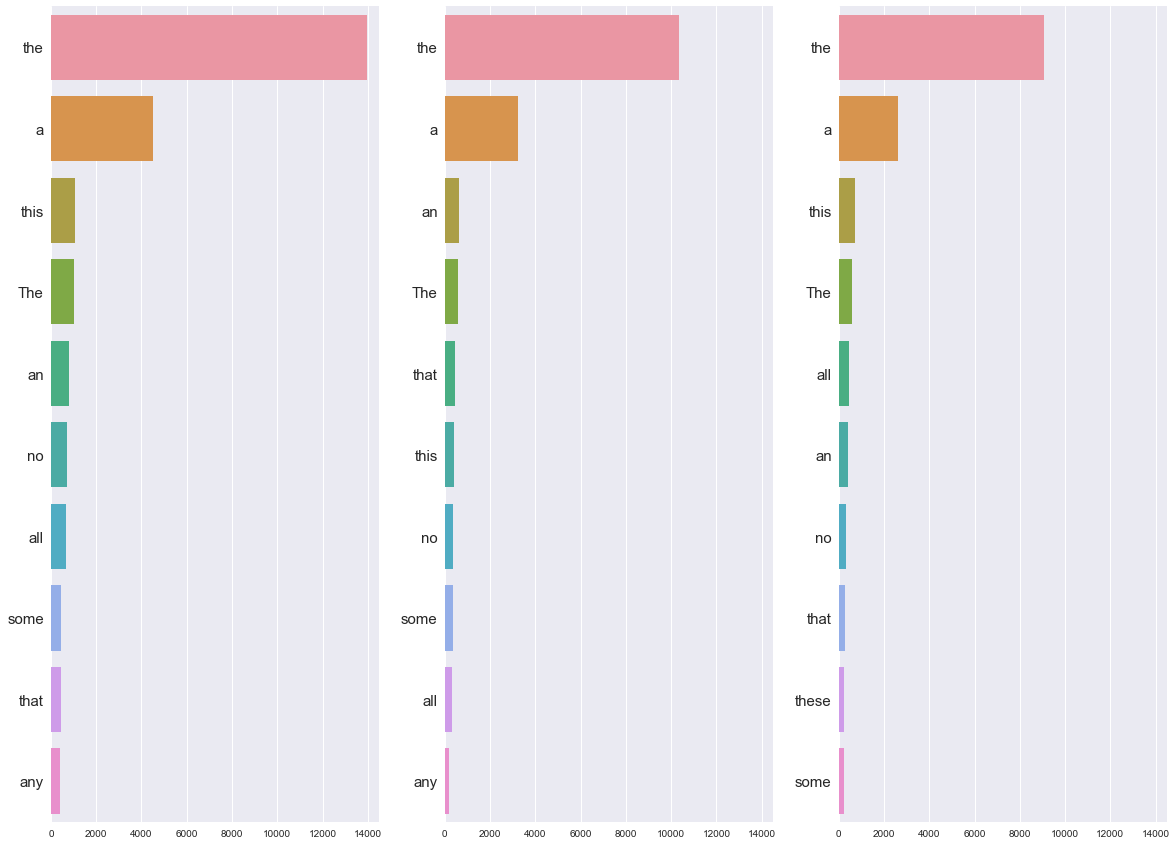

In [60]:
#冠词
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,14500)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,14500)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,14500)
plt.show()


In [40]:
EAP_PRP=[]
for i in range(len(train_data.PRP)):
    if train_data.author[i] == 'EAP':
        EAP_PRP+= train_data.PRP[i]

HPL_PRP=[]
for i in range(len(train_data.PRP)):
    if train_data.author[i] == 'HPL':
        HPL_PRP+= train_data.PRP[i]

MWS_PRP=[]
for i in range(len(train_data.PRP)):
    if train_data.author[i] == 'MWS':
        MWS_PRP+= train_data.PRP[i]


In [41]:
freq_EAP_PRP = nltk.FreqDist(EAP_PRP)
freq_HPL_PRP = nltk.FreqDist(HPL_PRP)
freq_MWS_PRP = nltk.FreqDist(MWS_PRP)

In [42]:
eap_prp_listkey = []
eap_prp_listval = []
for key, val in sorted (freq_EAP_PRP.items(),key=lambda x: (x[1], x[0]), reverse=True)[:15]:
    eap_prp_listkey.append(key)
    eap_prp_listval.append(val)
    
hpl_prp_listkey = []
hpl_prp_listval = []
for key, val in sorted (freq_HPL_PRP.items(),key=lambda x: (x[1], x[0]), reverse=True)[:15]:
    hpl_prp_listkey.append(key)
    hpl_prp_listval.append(val)
    
mws_prp_listkey = []
mws_prp_listval = []
for key, val in sorted (freq_MWS_PRP.items(),key=lambda x: (x[1], x[0]), reverse=True)[:15]:
    mws_prp_listkey.append(key)
    mws_prp_listval.append(val)

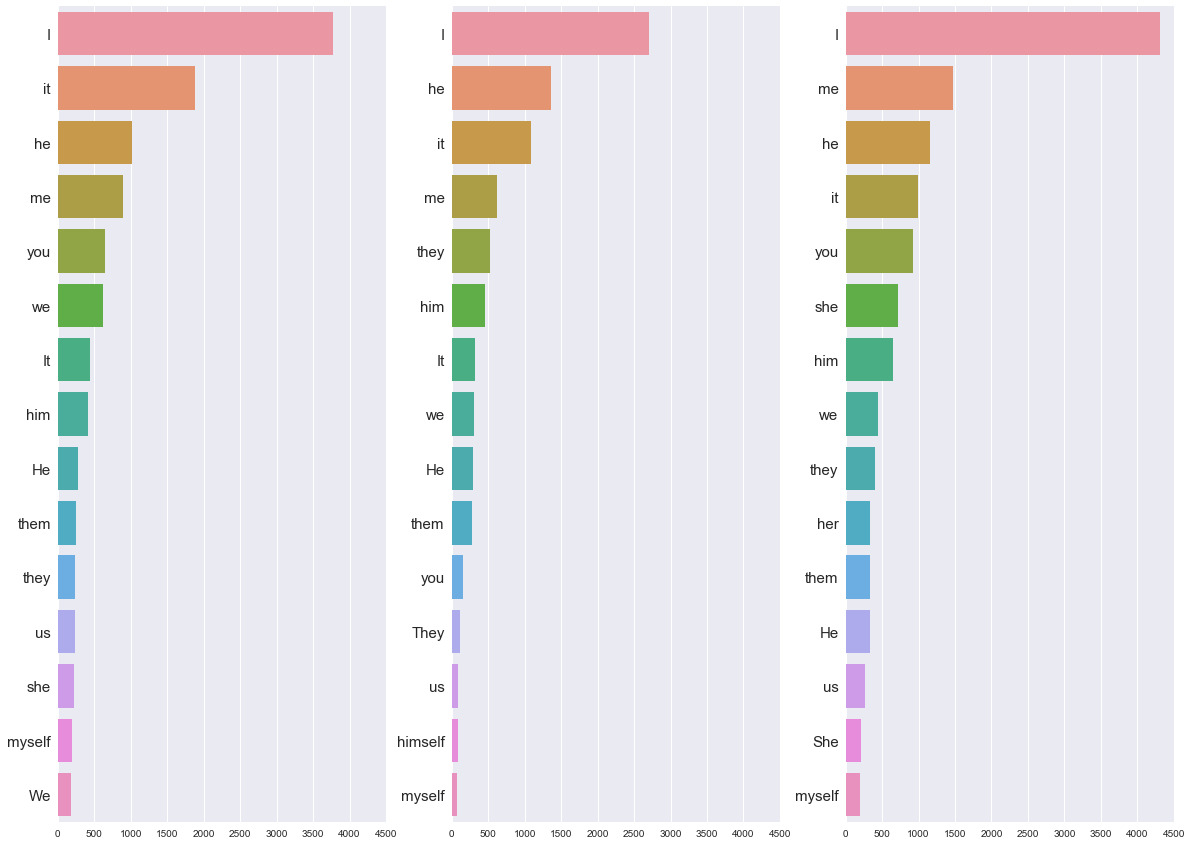

In [58]:
#代词
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_prp_listkey,x=eap_prp_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,4500)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_prp_listkey,x=hpl_prp_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,4500)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_prp_listkey,x=mws_prp_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,4500)

plt.show()

In [26]:
EAP_PRPS=[]
for i in range(len(train_data.PRP_)):
    if train_data.author[i] == 'EAP':
        EAP_PRPS+= train_data.PRP_[i]

HPL_PRPS=[]
for i in range(len(train_data.PRP_)):
    if train_data.author[i] == 'HPL':
        HPL_PRPS+= train_data.PRP_[i]

MWS_PRPS=[]
for i in range(len(train_data.PRP_)):
    if train_data.author[i] == 'MWS':
        MWS_PRPS+= train_data.PRP_[i]

In [31]:
freq_EAP_PRPS = nltk.FreqDist(EAP_PRPS)
freq_HPL_PRPS = nltk.FreqDist(HPL_PRPS)
freq_MWS_PRPS = nltk.FreqDist(MWS_PRPS)
eap_prps_listkey = []
eap_prps_listval = []
for key, val in sorted (freq_EAP_PRPS.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_prps_listkey.append(key)
    eap_prps_listval.append(val)
    
hpl_prps_listkey = []
hpl_prps_listval = []
for key, val in sorted (freq_HPL_PRPS.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_prps_listkey.append(key)
    hpl_prps_listval.append(val)
    
mws_prps_listkey = []
mws_prps_listval = []
for key, val in sorted (freq_MWS_PRPS.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_prps_listkey.append(key)
    mws_prps_listval.append(val)

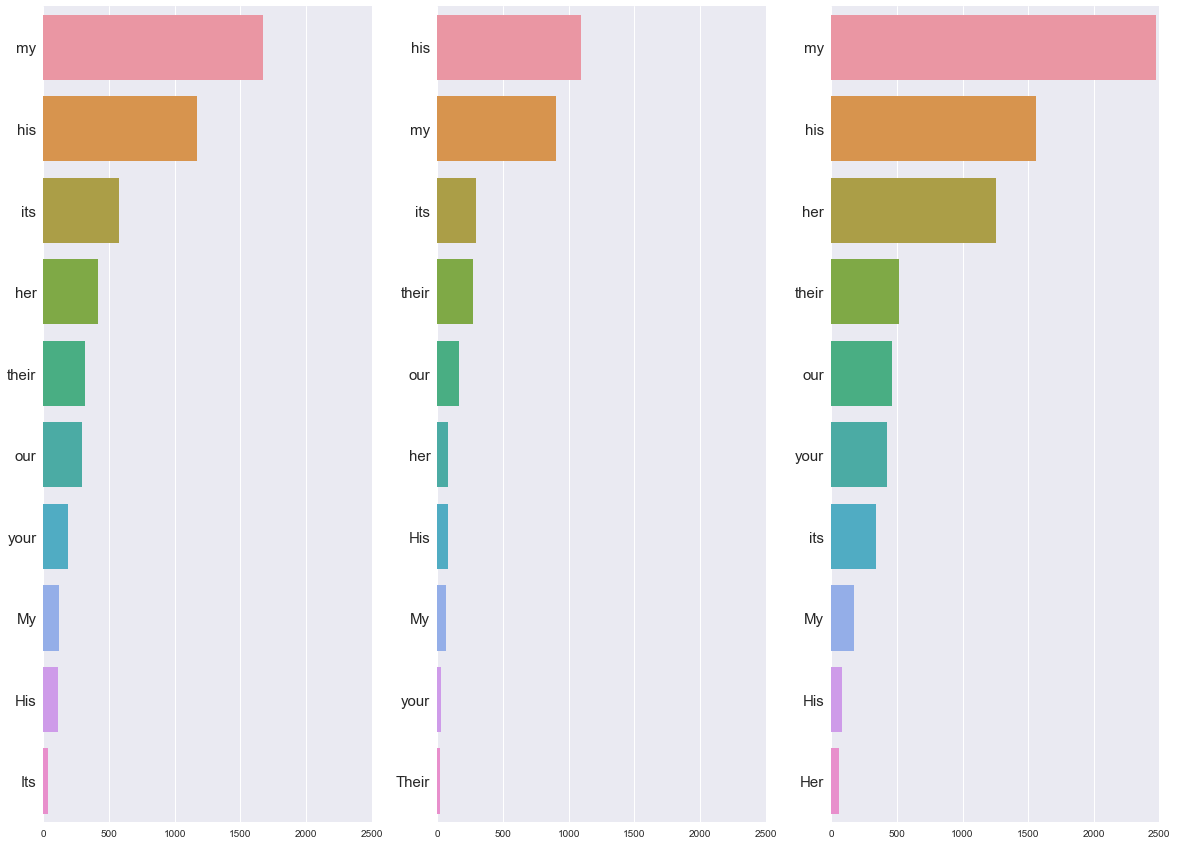

In [57]:
#mws 明显更喜欢使用 物主代词
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_prps_listkey,x=eap_prps_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,2500)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_prps_listkey,x=hpl_prps_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,2500)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_prps_listkey,x=mws_prps_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,2500)
plt.show()

In [52]:
EAP_IN=[]
for i in range(len(train_data.IN)):
    if train_data.author[i] == 'EAP':
        EAP_IN+= train_data.IN[i]

HPL_IN=[]
for i in range(len(train_data.IN)):
    if train_data.author[i] == 'HPL':
        HPL_IN+= train_data.IN[i]

MWS_IN=[]
for i in range(len(train_data.IN)):
    if train_data.author[i] == 'MWS':
        MWS_IN+= train_data.IN[i]


In [53]:
freq_EAP_IN = nltk.FreqDist(EAP_IN)
freq_HPL_IN = nltk.FreqDist(HPL_IN)
freq_MWS_IN = nltk.FreqDist(MWS_IN)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_IN.items(),key=lambda x: (x[1], x[0]), reverse=True)[:20]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_IN.items(),key=lambda x: (x[1], x[0]), reverse=True)[:20]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_IN.items(),key=lambda x: (x[1], x[0]), reverse=True)[:20]:
    mws_listkey.append(key)
    mws_listval.append(val)

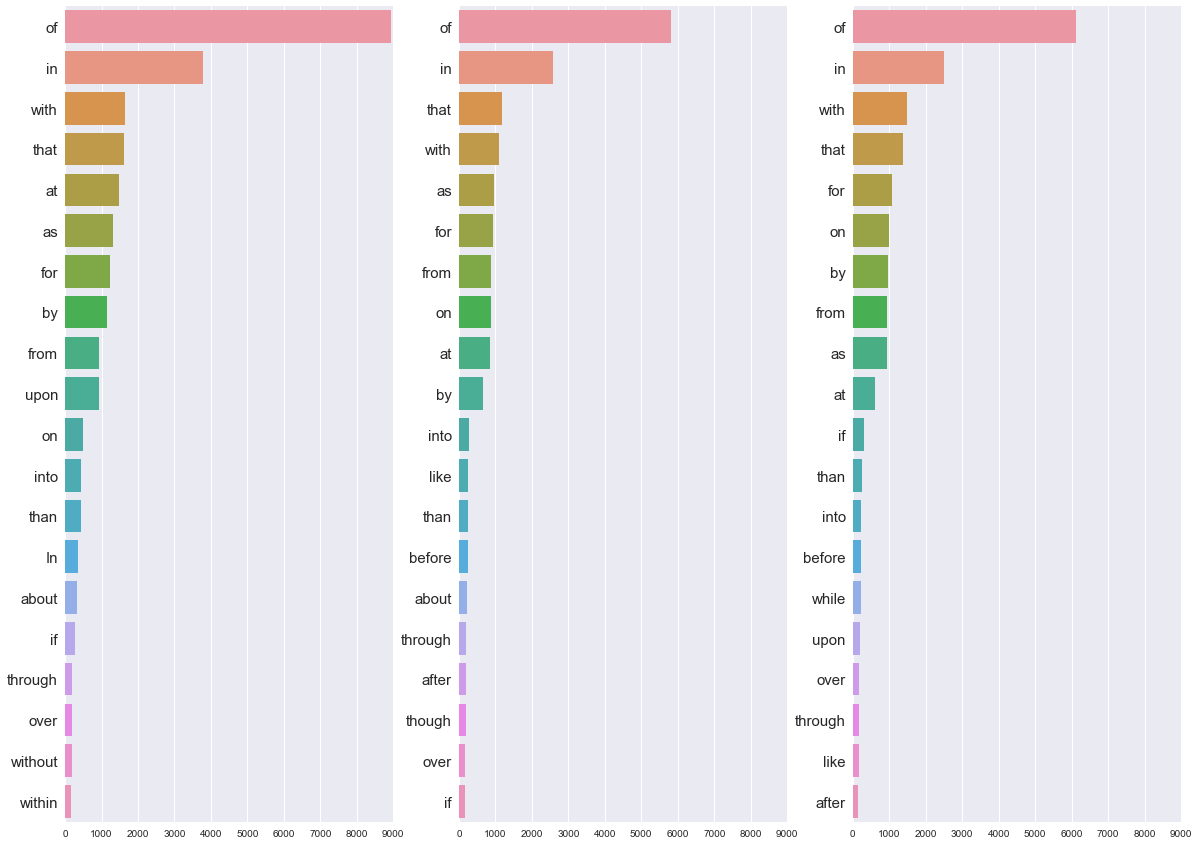

In [56]:
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,9000)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,9000)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,9000)
plt.show()


In [63]:
EAP_CC=[]
for i in range(len(train_data.CC)):
    if train_data.author[i] == 'EAP':
        EAP_CC+= train_data.CC[i]

HPL_CC=[]
for i in range(len(train_data.CC)):
    if train_data.author[i] == 'HPL':
        HPL_CC+= train_data.CC[i]

MWS_CC=[]
for i in range(len(train_data.CC)):
    if train_data.author[i] == 'MWS':
        MWS_CC+= train_data.CC[i]

In [64]:
freq_EAP_CC = nltk.FreqDist(EAP_CC)
freq_HPL_CC = nltk.FreqDist(HPL_CC)
freq_MWS_CC = nltk.FreqDist(MWS_CC)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_CC.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_CC.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_CC.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_listkey.append(key)
    mws_listval.append(val)

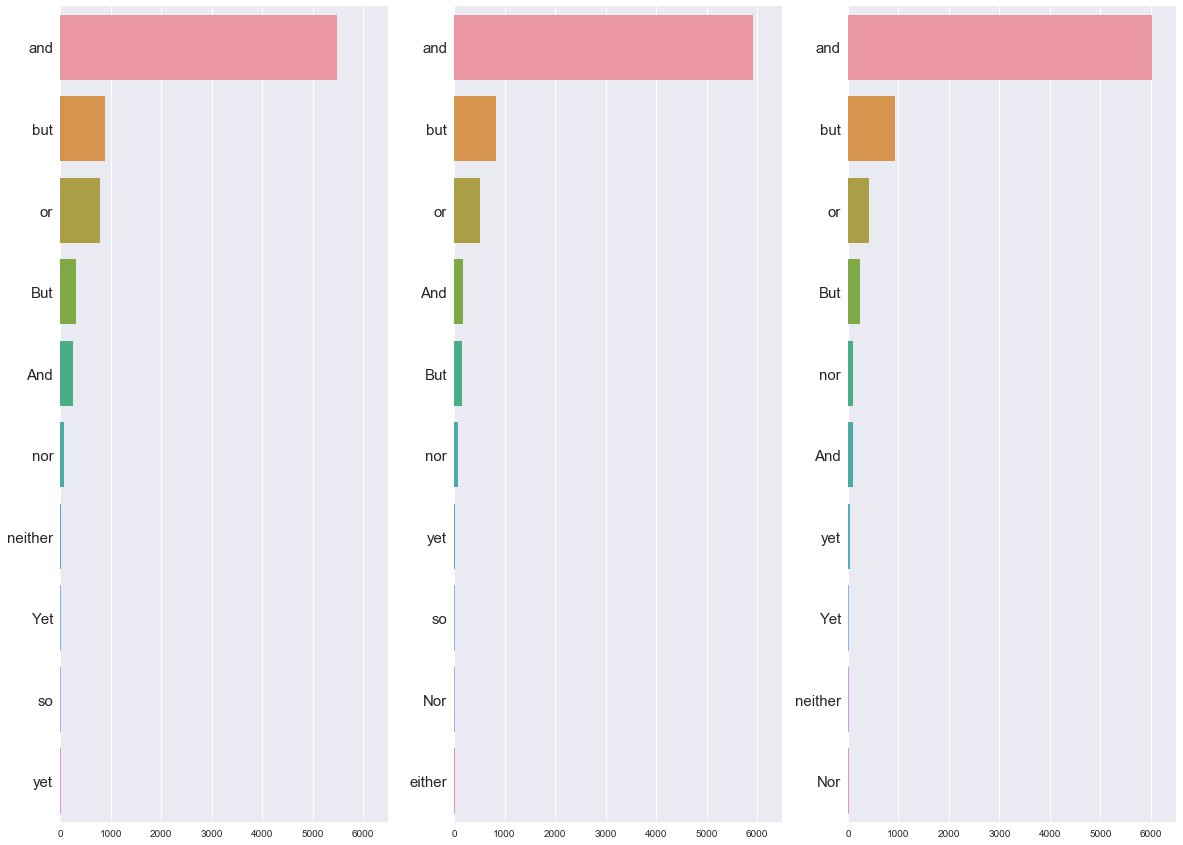

In [65]:
#连词几乎没有区别
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,6500)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,6500)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,6500)
plt.show()

In [66]:
EAP_VBD=[]
for i in range(len(train_data.VBD)):
    if train_data.author[i] == 'EAP':
        EAP_VBD+= train_data.VBD[i]

HPL_VBD=[]
for i in range(len(train_data.VBD)):
    if train_data.author[i] == 'HPL':
        HPL_VBD+= train_data.VBD[i]

MWS_VBD=[]
for i in range(len(train_data.VBD)):
    if train_data.author[i] == 'MWS':
        MWS_VBD+= train_data.VBD[i]

In [67]:
freq_EAP_VBD = nltk.FreqDist(EAP_VBD)
freq_HPL_VBD = nltk.FreqDist(HPL_VBD)
freq_MWS_VBD = nltk.FreqDist(MWS_VBD)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_VBD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_VBD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_VBD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_listkey.append(key)
    mws_listval.append(val)

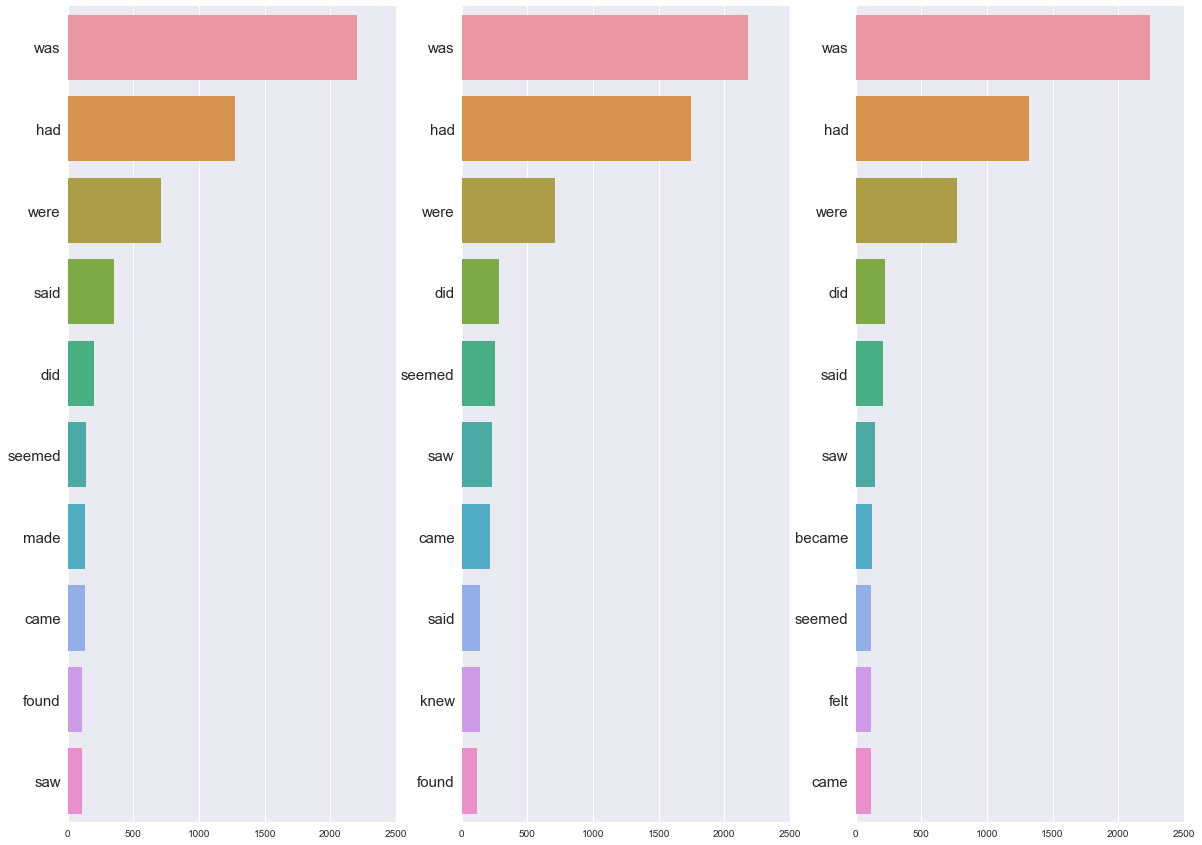

In [69]:
#过去式 几乎没有区别
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,2500)

ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,2500)

ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,2500)
plt.show()

In [70]:
EAP_UH=[]
for i in range(len(train_data.UH)):
    if train_data.author[i] == 'EAP':
        EAP_UH+= train_data.UH[i]

HPL_UH=[]
for i in range(len(train_data.UH)):
    if train_data.author[i] == 'HPL':
        HPL_UH+= train_data.UH[i]

MWS_UH=[]
for i in range(len(train_data.UH)):
    if train_data.author[i] == 'MWS':
        MWS_UH+= train_data.UH[i]

In [71]:
freq_EAP_UH = nltk.FreqDist(EAP_UH)
freq_HPL_UH = nltk.FreqDist(HPL_UH)
freq_MWS_UH = nltk.FreqDist(MWS_UH)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_UH.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_UH.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_UH.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_listkey.append(key)
    mws_listval.append(val)

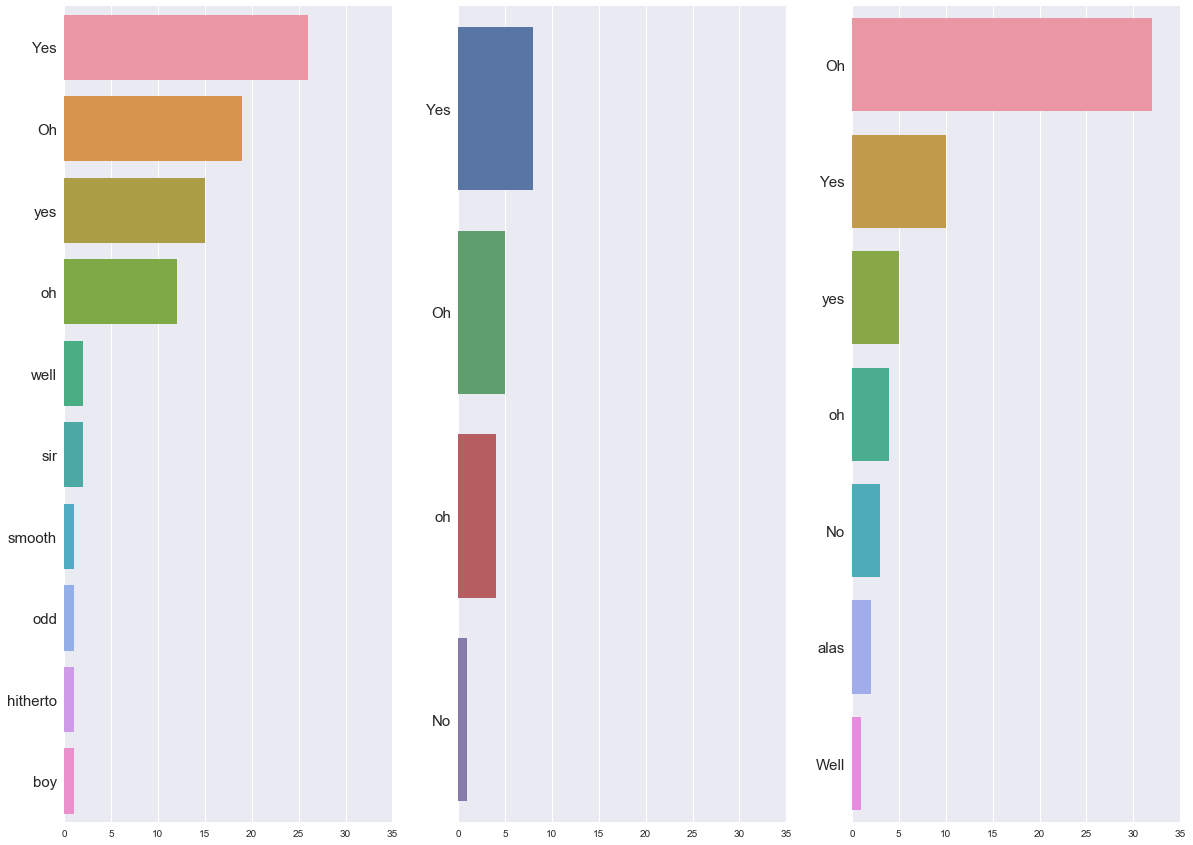

In [72]:
#语气词，HPL很少使用语气词，使用种类少，数量也少
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,35)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,35)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.xlim(0,35)
plt.yticks(fontsize=15)
plt.show()

In [74]:
EAP_FW=[]
for i in range(len(train_data.FW)):
    if train_data.author[i] == 'EAP':
        EAP_FW+= train_data.FW[i]

HPL_FW=[]
for i in range(len(train_data.FW)):
    if train_data.author[i] == 'HPL':
        HPL_FW+= train_data.FW[i]

MWS_FW=[]
for i in range(len(train_data.FW)):
    if train_data.author[i] == 'MWS':
        MWS_FW+= train_data.FW[i]
        
freq_EAP_FW = nltk.FreqDist(EAP_FW)
freq_HPL_FW = nltk.FreqDist(HPL_FW)
freq_MWS_FW = nltk.FreqDist(MWS_FW)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_FW.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_FW.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_FW.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_listkey.append(key)
    mws_listval.append(val)

In [117]:
#外语词使用差别巨大
print(len(EAP_FW))
print(len(HPL_FW))
print(len(MWS_FW))

194
26
15


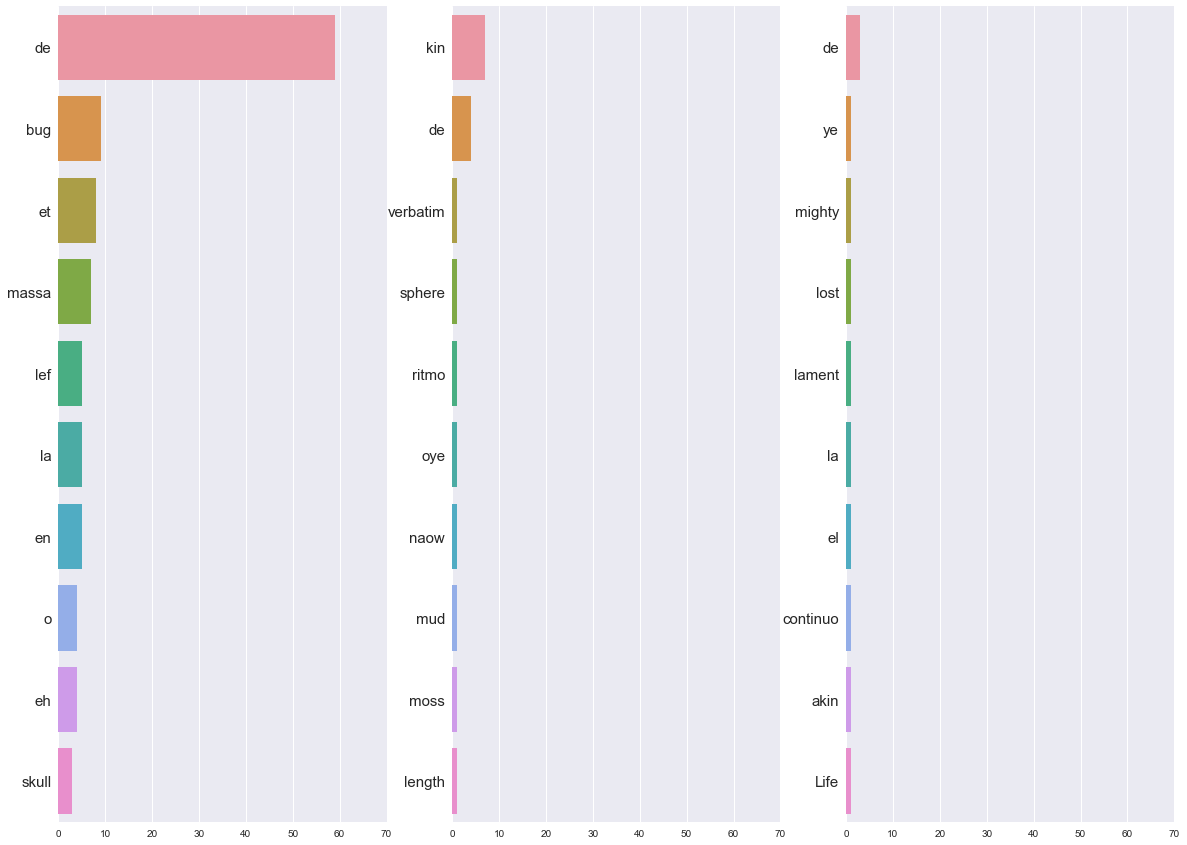

In [79]:
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,70)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,70)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.xlim(0,70)
plt.yticks(fontsize=15)
plt.show()

In [80]:
EAP_MD=[]
for i in range(len(train_data.MD)):
    if train_data.author[i] == 'EAP':
        EAP_MD+= train_data.MD[i]

HPL_MD=[]
for i in range(len(train_data.MD)):
    if train_data.author[i] == 'HPL':
        HPL_MD+= train_data.MD[i]

MWS_MD=[]
for i in range(len(train_data.MD)):
    if train_data.author[i] == 'MWS':
        MWS_MD+= train_data.MD[i]
        
freq_EAP_MD = nltk.FreqDist(EAP_MD)
freq_HPL_MD = nltk.FreqDist(HPL_MD)
freq_MWS_MD = nltk.FreqDist(MWS_MD)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_MD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_MD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_MD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_listkey.append(key)
    mws_listval.append(val)

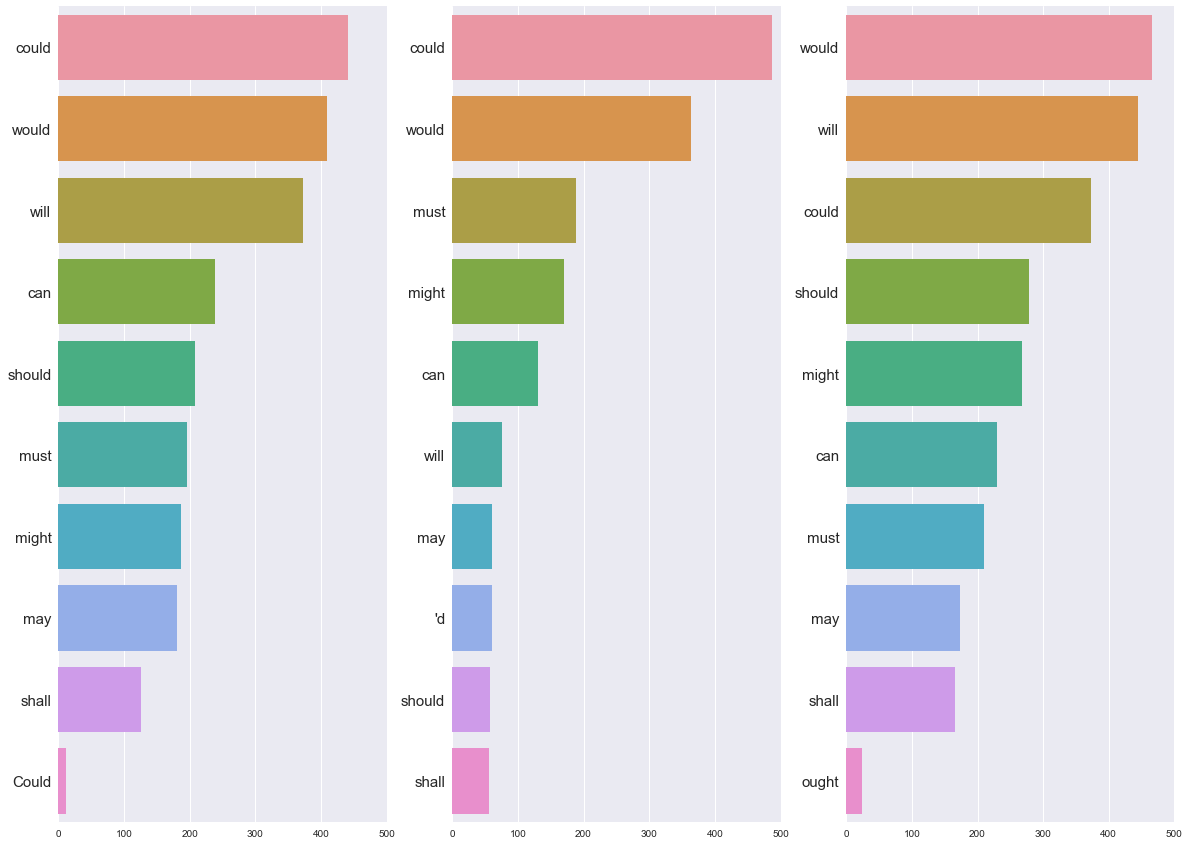

In [82]:
#情态动词没什么差别
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,500)
ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,500)
ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.xlim(0,500)
plt.yticks(fontsize=15)
plt.show()

In [98]:
EAP_NN=[]
for i in range(len(train_data.NN)):
    if train_data.author[i] == 'EAP':
        EAP_NN+= train_data.NN[i]

HPL_NN=[]
for i in range(len(train_data.NN)):
    if train_data.author[i] == 'HPL':
        HPL_NN+= train_data.NN[i]

MWS_NN=[]
for i in range(len(train_data.NN)):
    if train_data.author[i] == 'MWS':
        MWS_NN+= train_data.NN[i]
        
freq_EAP_NN = nltk.FreqDist(EAP_NN)
freq_HPL_NN = nltk.FreqDist(HPL_NN)
freq_MWS_NN = nltk.FreqDist(MWS_NN)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_NN.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_NN.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_NN.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    mws_listkey.append(key)
    mws_listval.append(val)

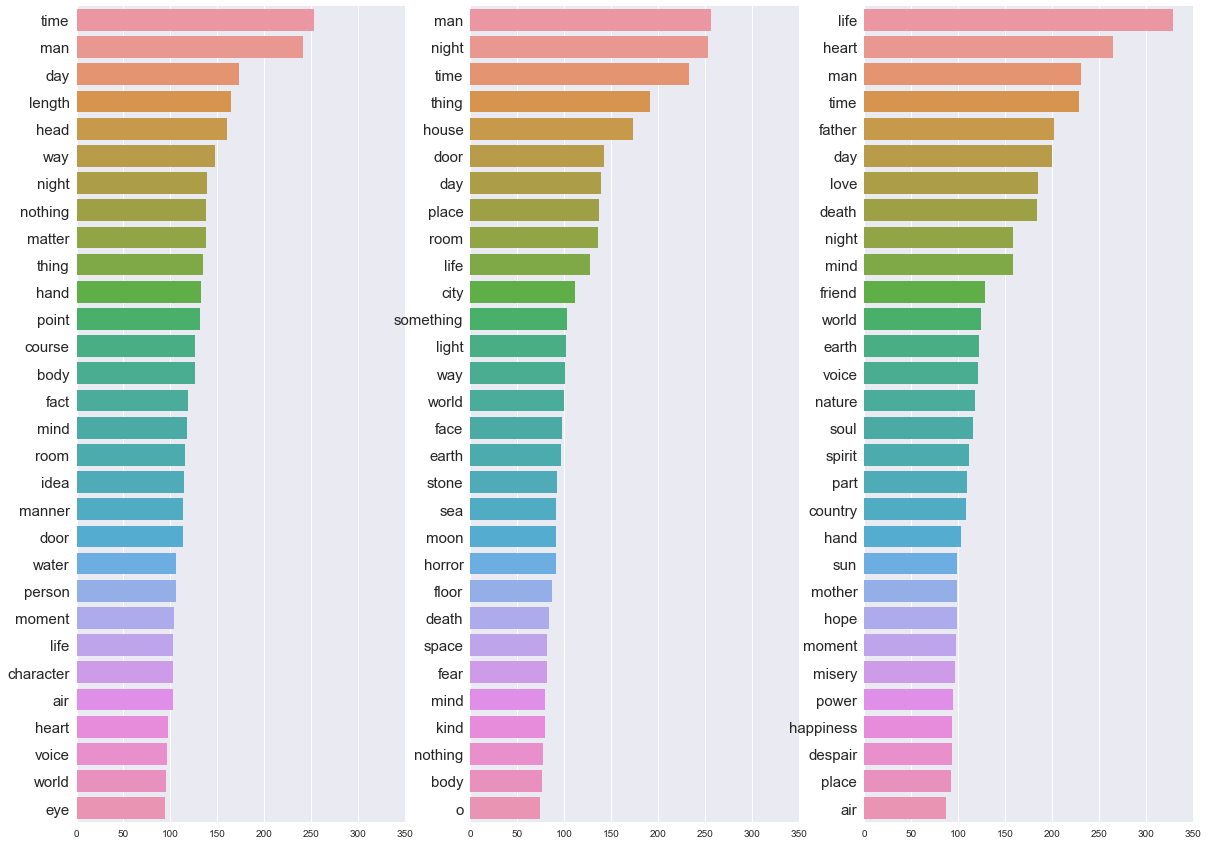

In [100]:
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,350)

ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,350)

ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.xlim(0,350)
plt.yticks(fontsize=15)

plt.show()

In [116]:
#mws 多使用love,death,heart 等抽象词语
for key,val in sorted (freq_EAP_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == ('love' or 'Love'):
        print(val)
for key,val in sorted (freq_HPL_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == ('love' or 'Love'):
        print(val)
for key,val in sorted (freq_MWS_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == ('love' or 'Love'):
        print(val)

39
5
185


In [94]:
for key,val in sorted (freq_EAP_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'heart':
        print(val)
for key,val in sorted (freq_HPL_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'heart':
        print(val)
for key,val in sorted (freq_MWS_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'heart':
        print(val)

97
12
265


In [95]:
for key,val in sorted (freq_EAP_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'death':
        print(val)
for key,val in sorted (freq_HPL_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'death':
        print(val)
for key,val in sorted (freq_MWS_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'death':
        print(val)

89
84
184


In [123]:
#hpl 使用house, room ,door等词较多
for key,val in sorted (freq_EAP_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'house':
        print(val)
for key,val in sorted (freq_HPL_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'house':
        print(val)
for key,val in sorted (freq_MWS_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'house':
        print(val)

90
173
74


In [126]:
#hpl 还常用stone
for key,val in sorted (freq_EAP_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'stone':
        print(val)
for key,val in sorted (freq_HPL_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'stone':
        print(val)
for key,val in sorted (freq_MWS_NN.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'stone':
        print(val)

17
92
8


In [120]:
EAP_NNP=[]
for i in range(len(train_data.NNP)):
    if train_data.author[i] == 'EAP':
        EAP_NNP+= train_data.NNP[i]

HPL_NNP=[]
for i in range(len(train_data.NNP)):
    if train_data.author[i] == 'HPL':
        HPL_NNP+= train_data.NNP[i]

MWS_NNP=[]
for i in range(len(train_data.NNP)):
    if train_data.author[i] == 'MWS':
        MWS_NNP+= train_data.NNP[i]
        
freq_EAP_NNP = nltk.FreqDist(EAP_NNP)
freq_HPL_NNP = nltk.FreqDist(HPL_NNP)
freq_MWS_NNP = nltk.FreqDist(MWS_NNP)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_NNP.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_NNP.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_NNP.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    mws_listkey.append(key)
    mws_listval.append(val)

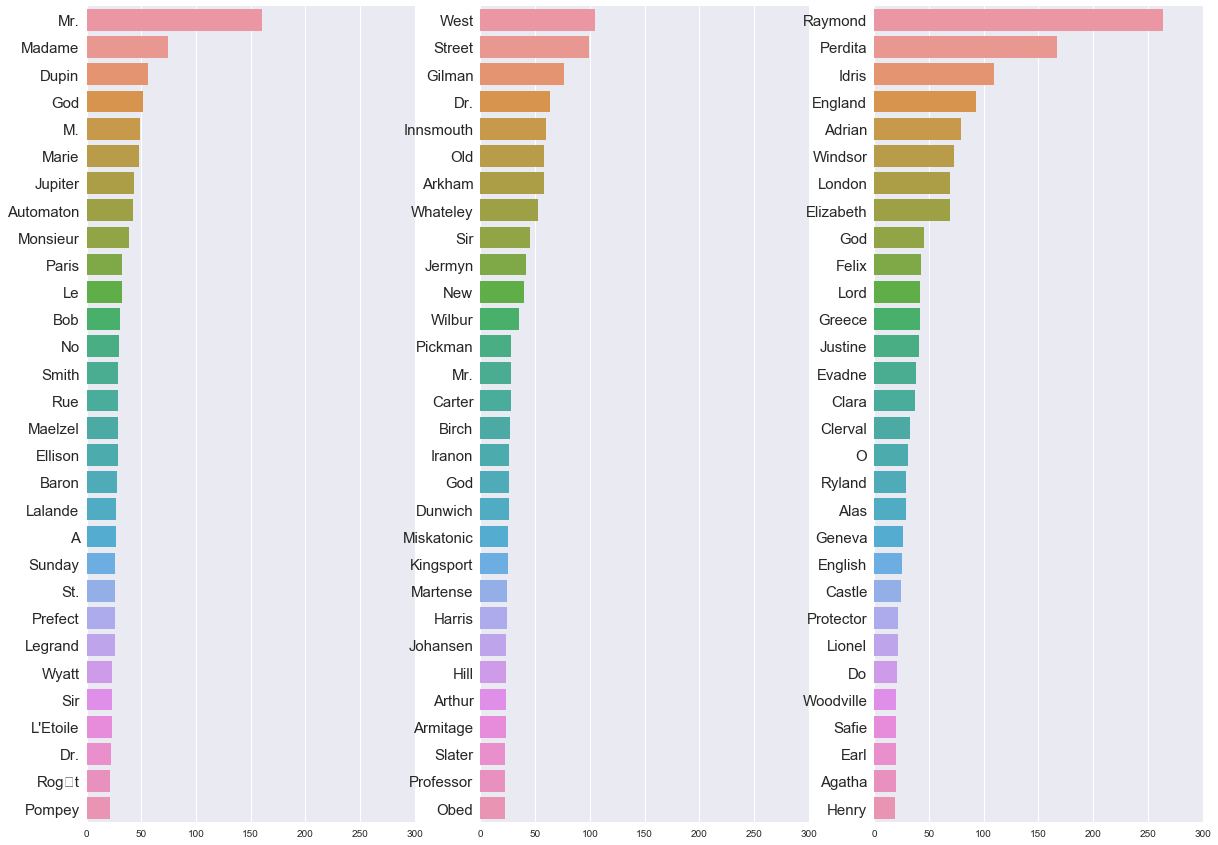

In [122]:
# 和stopwords去掉以后的结果相似，结合foreign word 可以看出EAP文中有很多法语词，MWS中很多英国元素
f = plt.figure(figsize=(20,15))
ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,300)

ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,300)

ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.xlim(0,300)
plt.yticks(fontsize=15)

plt.show()

In [108]:
EAP_JJ=[]
for i in range(len(train_data.JJ)):
    if train_data.author[i] == 'EAP':
        EAP_JJ+= train_data.JJ[i]

HPL_JJ=[]
for i in range(len(train_data.JJ)):
    if train_data.author[i] == 'HPL':
        HPL_JJ+= train_data.JJ[i]

MWS_JJ=[]
for i in range(len(train_data.JJ)):
    if train_data.author[i] == 'MWS':
        MWS_JJ+= train_data.JJ[i]
        
freq_EAP_JJ = nltk.FreqDist(EAP_JJ)
freq_HPL_JJ = nltk.FreqDist(HPL_JJ)
freq_MWS_JJ = nltk.FreqDist(MWS_JJ)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    mws_listkey.append(key)
    mws_listval.append(val)

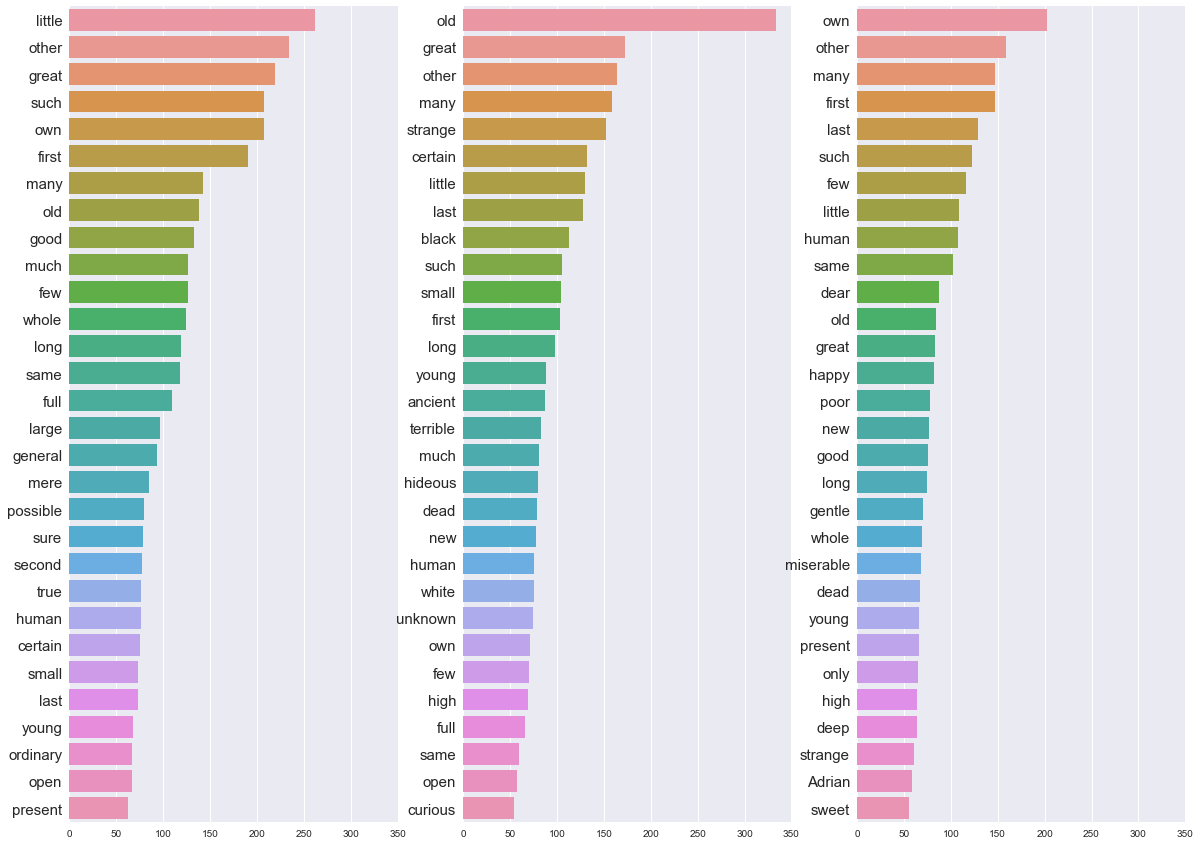

In [109]:
f = plt.figure(figsize=(20,15))

ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,350)

ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,350)

ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,350)

plt.show()

In [127]:
#hpl 常用black、strange这种负能量词语
for key,val in sorted (freq_EAP_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'black':
        print(val)
for key,val in sorted (freq_HPL_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'black':
        print(val)
for key,val in sorted (freq_MWS_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'black':
        print(val)

55
113
19


In [129]:

for key,val in sorted (freq_EAP_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'strange':
        print(val)
for key,val in sorted (freq_HPL_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'strange':
        print(val)
for key,val in sorted (freq_MWS_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'strange':
        print(val)

34
152
61


In [130]:
#mws 常用happy,dear,miserable这种正能量/情感类词语
for key,val in sorted (freq_EAP_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'dear':
        print(val)
for key,val in sorted (freq_HPL_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'dear':
        print(val)
for key,val in sorted (freq_MWS_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'dear':
        print(val)

21
1
87


In [ ]:
for key,val in sorted (freq_EAP_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'happy':
        print(val)
for key,val in sorted (freq_HPL_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'happy':
        print(val)
for key,val in sorted (freq_MWS_JJ.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == 'happy':
        print(val)

In [110]:
EAP_RB=[]
for i in range(len(train_data.RB)):
    if train_data.author[i] == 'EAP':
        EAP_RB+= train_data.RB[i]

HPL_RB=[]
for i in range(len(train_data.RB)):
    if train_data.author[i] == 'HPL':
        HPL_RB+= train_data.RB[i]

MWS_RB=[]
for i in range(len(train_data.RB)):
    if train_data.author[i] == 'MWS':
        MWS_RB+= train_data.RB[i]
        
freq_EAP_RB = nltk.FreqDist(EAP_RB)
freq_HPL_RB = nltk.FreqDist(HPL_RB)
freq_MWS_RB = nltk.FreqDist(MWS_RB)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_RB.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_RB.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_RB.items(),key=lambda x: (x[1], x[0]), reverse=True)[:30]:
    mws_listkey.append(key)
    mws_listval.append(val)

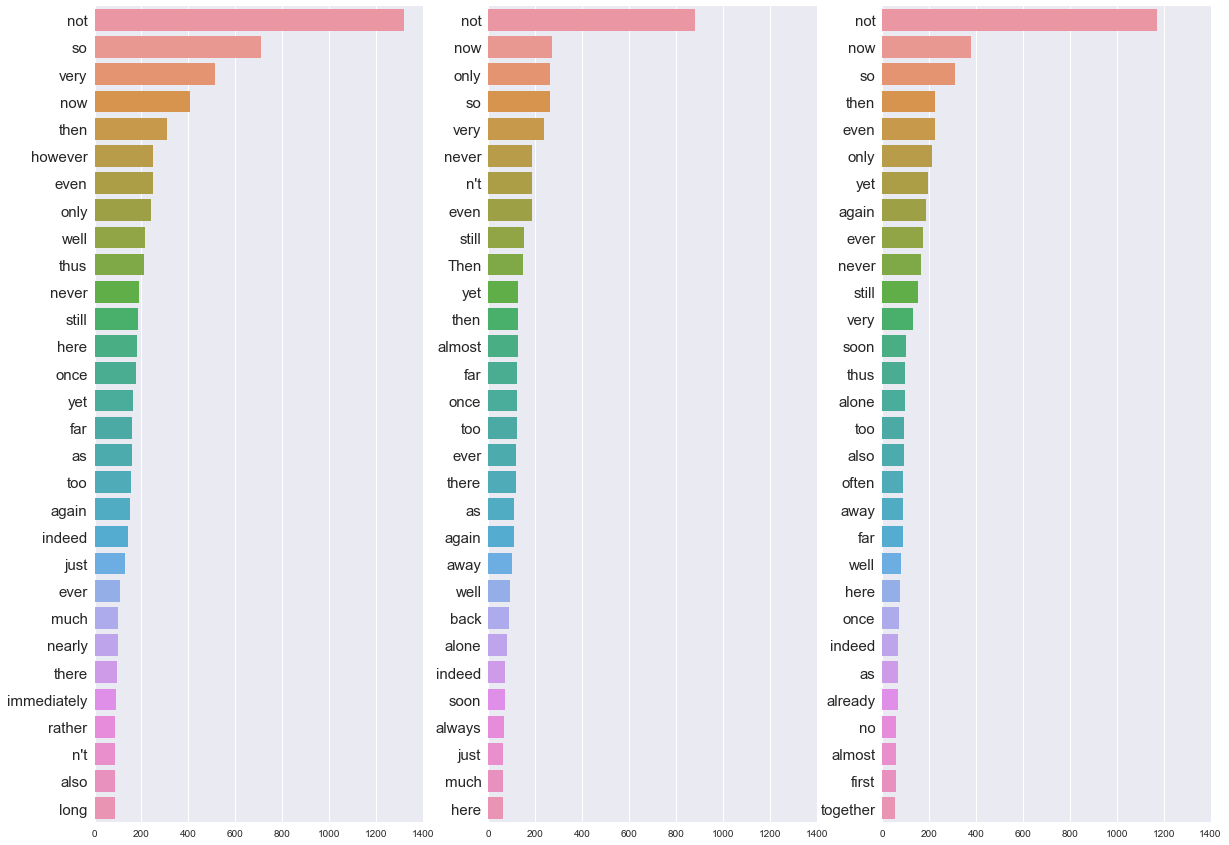

In [112]:
f = plt.figure(figsize=(20,15))

ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,1400)

ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,1400)

ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,1400)

plt.show()

In [115]:
#however 使用差别大
for key,val in sorted (freq_EAP_RB.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == ('however'or'However'):
        print(val)
for key,val in sorted (freq_HPL_RB.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == ('however'or'However'):
        print(val)
for key,val in sorted (freq_MWS_RB.items(),key=lambda x: (x[1], x[0]), reverse=True):
   if key == ('however'or'However'):
        print(val)

251
47
49


In [131]:
EAP_CD=[]
for i in range(len(train_data.CD)):
    if train_data.author[i] == 'EAP':
        EAP_CD+= train_data.CD[i]

HPL_CD=[]
for i in range(len(train_data.CD)):
    if train_data.author[i] == 'HPL':
        HPL_CD+= train_data.CD[i]

MWS_CD=[]
for i in range(len(train_data.CD)):
    if train_data.author[i] == 'MWS':
        MWS_CD+= train_data.CD[i]
        
freq_EAP_CD = nltk.FreqDist(EAP_CD)
freq_HPL_CD = nltk.FreqDist(HPL_CD)
freq_MWS_CD = nltk.FreqDist(MWS_CD)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_CD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:20]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_CD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:20]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_CD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:20]:
    mws_listkey.append(key)
    mws_listval.append(val)

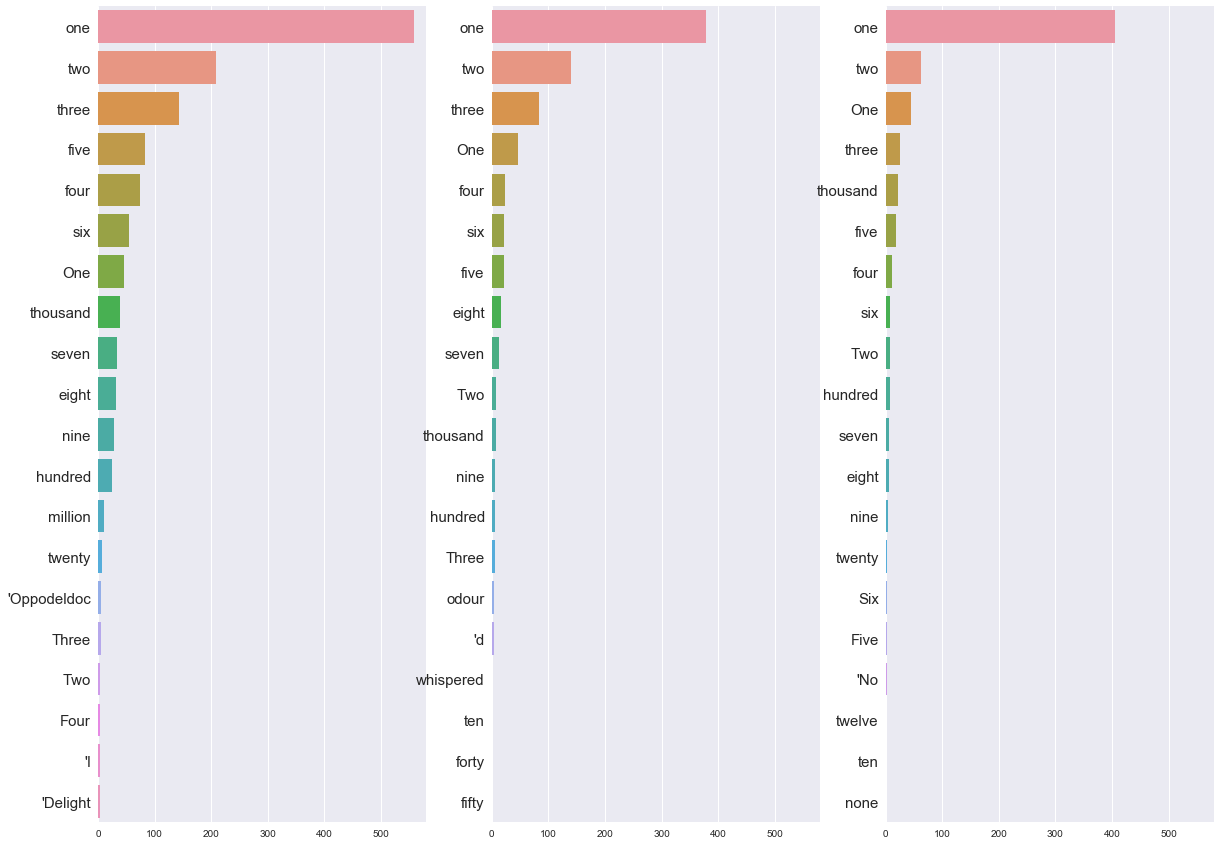

In [133]:
#数词没什么差别
f = plt.figure(figsize=(20,15))

ax1 = f.add_subplot(131)
sns.barplot(y=eap_listkey,x=eap_listval,ax=ax1)
plt.yticks(fontsize=15)
plt.xlim(0,580)

ax2 = f.add_subplot(132)
sns.barplot(y=hpl_listkey,x=hpl_listval,ax=ax2)
plt.yticks(fontsize=15)
plt.xlim(0,580)

ax3 = f.add_subplot(133)
sns.barplot(y=mws_listkey,x=mws_listval,ax=ax3)
plt.yticks(fontsize=15)
plt.xlim(0,580)

plt.show()

In [ ]:
EAP_MD=[]
for i in range(len(train_data.MD)):
    if train_data.author[i] == 'EAP':
        EAP_MD+= train_data.MD[i]

HPL_MD=[]
for i in range(len(train_data.MD)):
    if train_data.author[i] == 'HPL':
        HPL_MD+= train_data.MD[i]

MWS_MD=[]
for i in range(len(train_data.MD)):
    if train_data.author[i] == 'MWS':
        MWS_MD+= train_data.MD[i]
        
freq_EAP_MD = nltk.FreqDist(EAP_MD)
freq_HPL_MD = nltk.FreqDist(HPL_MD)
freq_MWS_MD = nltk.FreqDist(MWS_MD)

eap_listkey = []
eap_listval = []
for key, val in sorted (freq_EAP_MD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    eap_listkey.append(key)
    eap_listval.append(val)
    
hpl_listkey = []
hpl_listval = []
for key, val in sorted (freq_HPL_MD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    hpl_listkey.append(key)
    hpl_listval.append(val)
    
mws_listkey = []
mws_listval = []
for key, val in sorted (freq_MWS_MD.items(),key=lambda x: (x[1], x[0]), reverse=True)[:10]:
    mws_listkey.append(key)
    mws_listval.append(val)